In [104]:
%load_ext autoreload
import numpy as np
from tqdm import tqdm_notebook
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import os
from copy import copy
from itertools import combinations
from collections import defaultdict, Counter
from scipy.spatial import distance
from sklearn.metrics import silhouette_score, davies_bouldin_score, pairwise_distances
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering
from sklearn.manifold import TSNE
from scipy.spatial import distance
from IPython.core.debugger import set_trace
from utils import *
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
RANDOM_SEED=42
FIGSIZE=(5,5)
DPI=150
FONTSIZE=5

# Load data

In [3]:
# paths to the databases containing the PCA and Isomap projections 
root = './separate_datasets_transformed/'
root_pca = './separate_datasets_proj/'
DATASETS = ['AGP_proj_o', 'ptb_proj_o']
N_DATASETS = len(DATASETS)

paths = filter_paths([os.path.join(root,path) for path in os.listdir(root)], keywords=DATASETS)
paths_pca = filter_paths([os.path.join(root_pca,path) for path in os.listdir(root_pca)], keywords=DATASETS)
paths_mf_lle = filter_paths(paths, keywords=['lle'])
paths_mf_isomap = filter_paths(paths, keywords=['isomap'])
paths_mf_ae = filter_paths(paths, keywords=['ae'])

In [4]:
def unpack_data(paths):
    datasets = {}
    for path in paths:
        label = path.split('/')[-1].split('.')[0].split('_')[:3]
        label = '_'.join(label)
        try:
            datasets[label] = np.genfromtxt(path, delimiter=';')
        except:
            datasets[label] = np.load(path, allow_pickle=True)
    return datasets

In [5]:
data_pca = unpack_data(paths_pca)
data_lle = unpack_data(paths_mf_lle)
data_isomap = unpack_data(paths_mf_isomap)
data_ae = unpack_data(paths_mf_ae)

# PCA

In [35]:
LABEL2DBSCAN_PARAMS_PCA = {}
for (label,data),ax in zip(data_pca.items(), axes.flatten()):
    p95_list = get_neigh_perc(data)
    LABEL2DBSCAN_PARAMS_PCA[label] = [min(p95_list), max(p95_list)]

In [36]:
methods_dict_pca = {'dbscan':[DBSCAN, [None]*30],
                   'KMeans':[KMeans, np.arange(2, 10, 1)],
                   'SpectralClustering':[SpectralClustering, np.arange(2, 10, 1)]}

methods_names = list(methods_dict_pca.keys())

pca_cluster_results_list = []
pca_cluster_preds_list = []

for method_name in tqdm_notebook(methods_names):
    method_class, param_range = methods_dict_pca[method_name]
    cluster_results, cluster_preds = clustering(data_pca, 
                                                method_class, 
                                                param_range, 
                                                dbscan=method_name=='dbscan', 
                                                dbscan_params_dict=LABEL2DBSCAN_PARAMS_PCA)
    
    pca_cluster_results_list.append(cluster_results)
    pca_cluster_preds_list.append(cluster_preds)

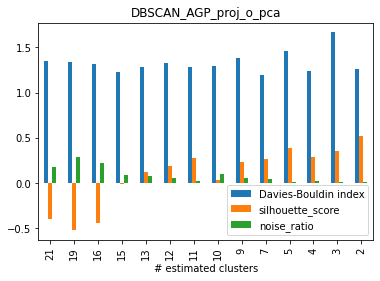

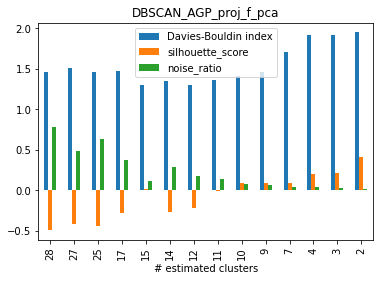

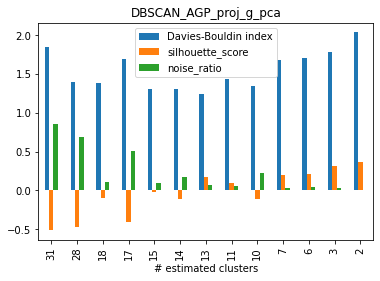

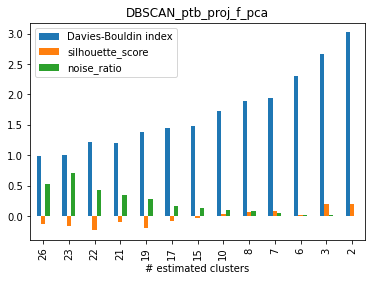

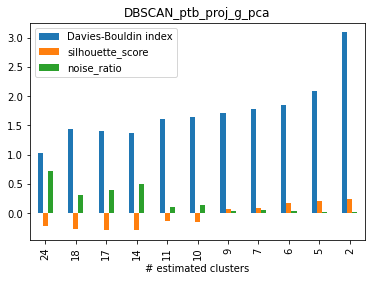

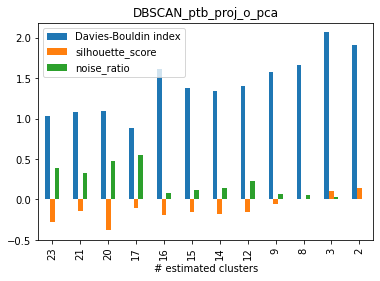

In [50]:
plot_proj_clustering(pca_cluster_results_list[0], method='pca', suptitle='DBSCAN')

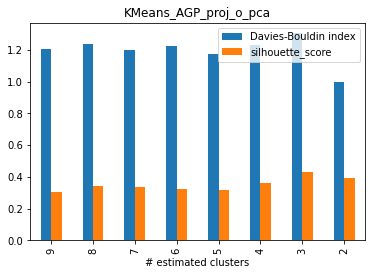

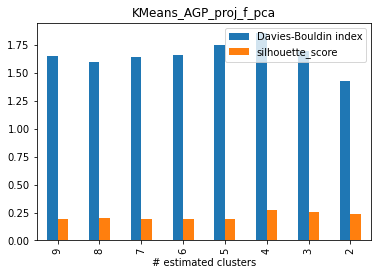

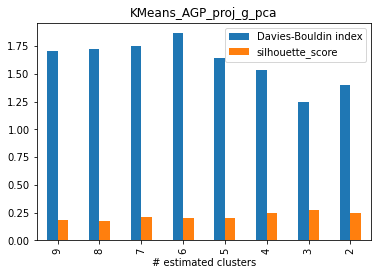

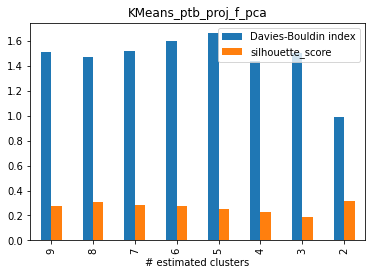

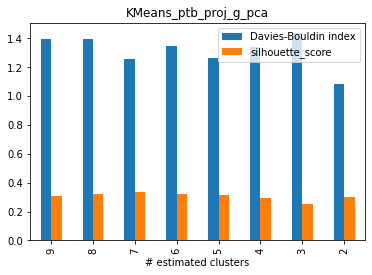

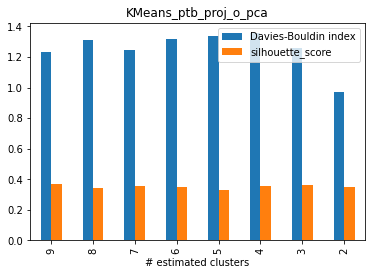

In [52]:
plot_proj_clustering(pca_cluster_results_list[1], method='pca', suptitle='KMeans')

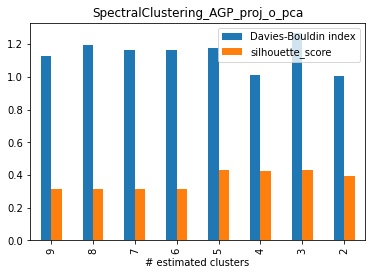

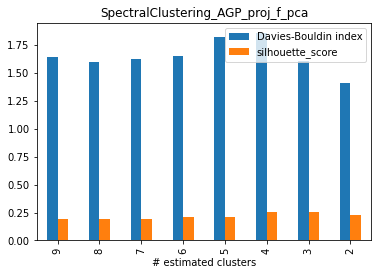

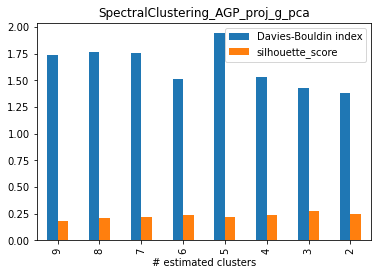

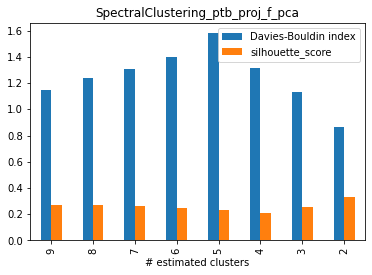

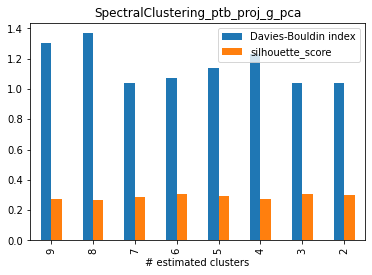

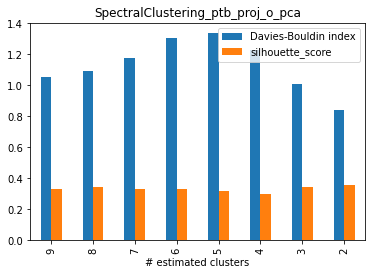

In [53]:
plot_proj_clustering(pca_cluster_results_list[2], method='pca', suptitle='SpectralClustering')

In [88]:
# get_report(methods_dict_pca, 
#            pca_cluster_results_list, 
#            pca_cluster_preds_list, 
#            silh_thresh=0.8,
#            H_thresh=0.3,
#            dbind_thresh=1.2)

NameError: name 'methods_dict_pca' is not defined

# AE

In [106]:
def plot_proj_clustering(clustering_results, method='', suptitle=None, data_default_metrics=None):
    '''
    clustering_results - dict
    '''
    results = copy(clustering_results)
    L = len(clustering_results)
    
    for label,data in results.items():
        if len(data) > 0:
            plt.figure(figsize=FIGSIZE, dpi=DPI)
            df = pd.DataFrame(data=data).T
            df.columns = ['Davies-Bouldin index', 'Silhouette score', 'noise_ratio']
            df.sort_index(ascending=False, inplace=True)
#             if df['noise_ratio'].sum() == 0.:
            df.drop('noise_ratio', axis=1, inplace=True)
            plt.xlabel('# estimated clusters', fontsize=FONTSIZE)
            dataset, _, tax = label.split('_'); tax = tax.capitalize()
            label = f'Dataset: {dataset}, Tax: {tax}'
            label = label + '\n' + method if len(method) > 0 else label
            plt.title(suptitle + ', ' + label if suptitle is not None else label, fontsize=FONTSIZE)
            df.plot.bar(ax=plt.gca())

            if data_default_metrics is not None:
                def_clust_type, Silhoette_default = data_default_metrics[label]
    #                         if not DB_default > 1.5*max(df['Davies-Bouldin index']):
    #                             ax.hlines(DB_default, 0, len(df.index), linestyles='dotted', colors='blue')
                ax.hlines(Silhoette_default, 0, len(df.index), linestyles='dotted', colors='orange', label=def_clust_type)
                ax.legend()
            plt.show()

In [107]:
LABEL2DBSCAN_PARAMS_AE = {}
for (label,data) in data_ae.items():
    p95_list = get_neigh_perc(data)
    LABEL2DBSCAN_PARAMS_AE[label] = [min(p95_list), max(p95_list)]

In [108]:
methods_dict_ae = {'dbscan':[DBSCAN, [None]*30],
                   'KMeans':[KMeans, np.arange(2, 10, 1)]}
#                    'SpectralClustering':[SpectralClustering, np.arange(2, 10, 1)]}

methods_names = list(methods_dict_ae.keys())

ae_cluster_results_list = []
ae_cluster_preds_list = []

for method_name in tqdm_notebook(methods_names):
    method_class, param_range = methods_dict_ae[method_name]
    cluster_results, cluster_preds = clustering(data_ae, 
                                                method_class, 
                                                param_range, 
                                                dbscan=method_name=='dbscan', 
                                                dbscan_params_dict=LABEL2DBSCAN_PARAMS_AE)
    
    ae_cluster_results_list.append(cluster_results)
    ae_cluster_preds_list.append(cluster_preds)

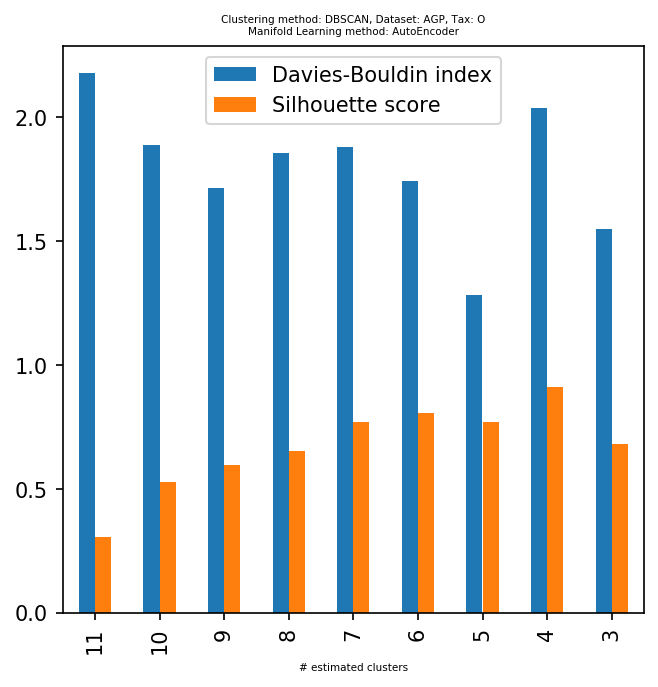

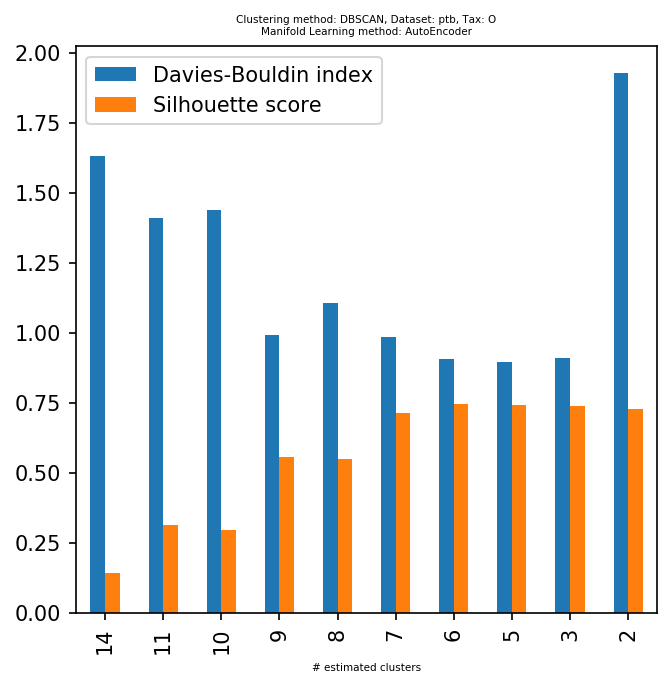

In [109]:
plot_proj_clustering(ae_cluster_results_list[0], method='Manifold Learning method: AutoEncoder', suptitle='Clustering method: DBSCAN')

In [119]:
get_report(methods_dict_ae, 
           ae_cluster_results_list, 
           ae_cluster_preds_list, 
           silh_thresh=0.5,
           H_thresh=0.0,
           noise_thresh=1.,
           dbind_thresh=1.5)

------------------------------
dbscan
Ratio for ptb_proj_o, for n_clusters=3, H=0.11845665607511982, ratios=[0.012 0.979 0.002 0.007], DBind=0.9088920035911556, Silh=0.7361202836036682
------------------------------
------------------------------
KMeans
Ratio for AGP_proj_o, for n_clusters=2, H=0.02948614354067412, ratios=[0.995 0.005], DBind=0.35655038459835187, Silh=0.9492103457450867
Ratio for AGP_proj_o, for n_clusters=3, H=0.037458474115854956, ratios=[0.994 0.004 0.001], DBind=0.4435446705697368, Silh=0.9305437207221985
Ratio for AGP_proj_o, for n_clusters=4, H=0.1432267445690053, ratios=[0.972 0.004 0.023 0.001], DBind=0.8944501237156794, Silh=0.7328149080276489
Ratio for ptb_proj_o, for n_clusters=2, H=0.07069432448381752, ratios=[0.987 0.013], DBind=0.37478200759759916, Silh=0.8707494735717773
Ratio for ptb_proj_o, for n_clusters=3, H=0.4124717883420692, ratios=[0.878 0.108 0.013], DBind=1.2379530783244135, Silh=0.5480197668075562
Ratio for ptb_proj_o, for n_clusters=4, H=0.48

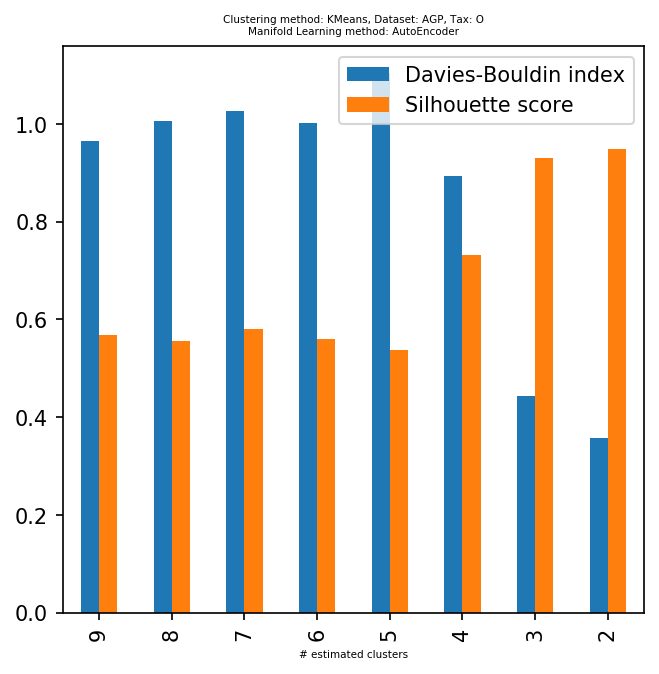

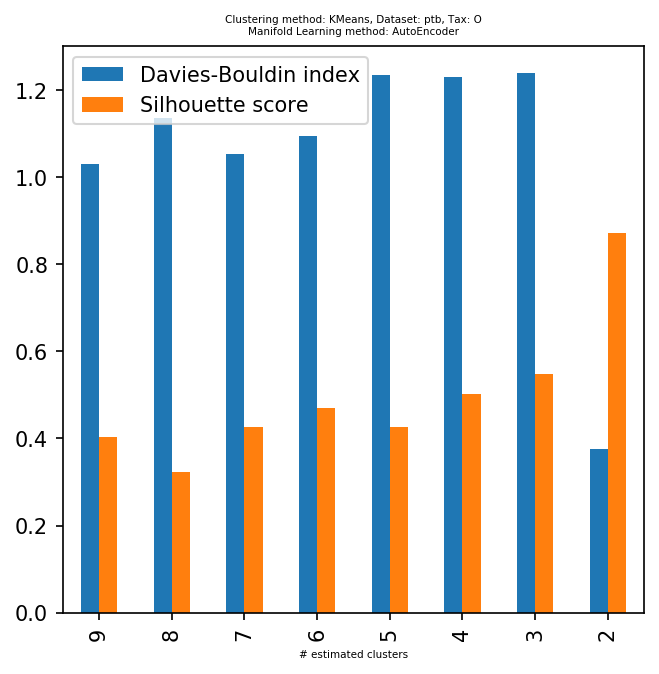

In [111]:
plot_proj_clustering(ae_cluster_results_list[1], method='Manifold Learning method: AutoEncoder', suptitle='Clustering method: KMeans')

# Isomap

In [89]:
LABEL2DBSCAN_PARAMS_ISOMAP = {}
for (label,data) in data_isomap.items():
    p95_list = get_neigh_perc(data)
    LABEL2DBSCAN_PARAMS_ISOMAP[label] = [min(p95_list), max(p95_list)]

In [90]:
methods_dict_isomap = {'dbscan':[DBSCAN, [None]*30],
                       'KMeans':[KMeans, np.arange(2, 10, 1)]}
#                        'SpectralClustering':[SpectralClustering, np.arange(2, 10, 1)]}

methods_names = list(methods_dict_isomap.keys())

isomap_cluster_results_list = []
isomap_cluster_preds_list = []

for method_name in tqdm_notebook(methods_names):
    method_class, param_range = methods_dict_isomap[method_name]
    cluster_results, cluster_preds = clustering(data_isomap, 
                                                method_class, 
                                                param_range, 
                                                dbscan=method_name=='dbscan', 
                                                dbscan_params_dict=LABEL2DBSCAN_PARAMS_ISOMAP)
    
    isomap_cluster_results_list.append(cluster_results)
    isomap_cluster_preds_list.append(cluster_preds)

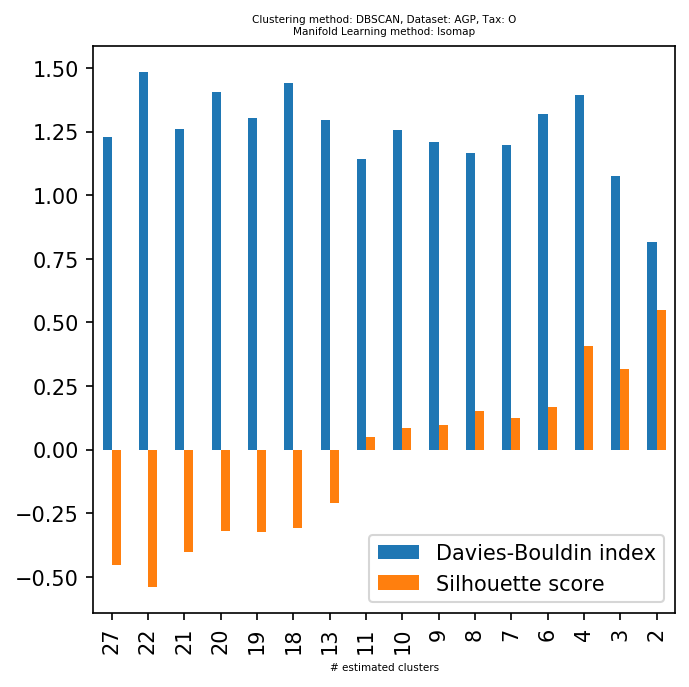

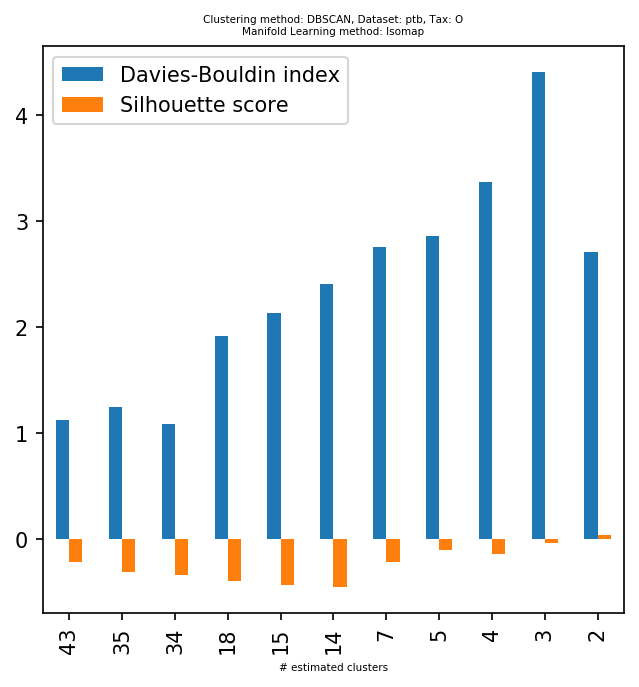

In [112]:
plot_proj_clustering(isomap_cluster_results_list[0], method='Manifold Learning method: Isomap', suptitle='Clustering method: DBSCAN')

In [113]:
get_report(methods_dict_isomap, 
           isomap_cluster_results_list, 
           isomap_cluster_preds_list, 
           silh_thresh=0.0,
           H_thresh=0.0,
           dbind_thresh=0.0)

------------------------------
dbscan
------------------------------
------------------------------
KMeans
------------------------------


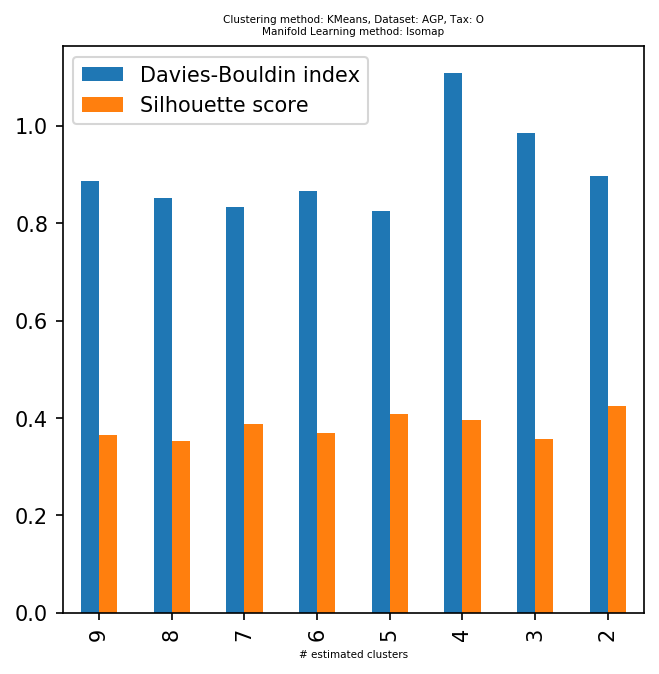

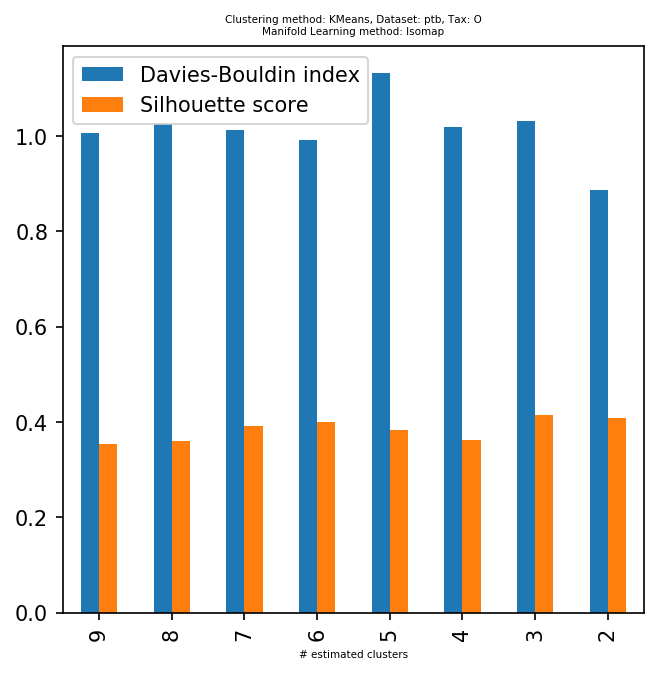

In [114]:
plot_proj_clustering(isomap_cluster_results_list[1], method='Manifold Learning method: Isomap', suptitle='Clustering method: KMeans')

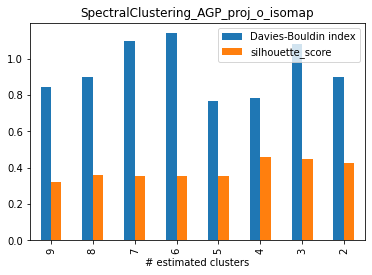

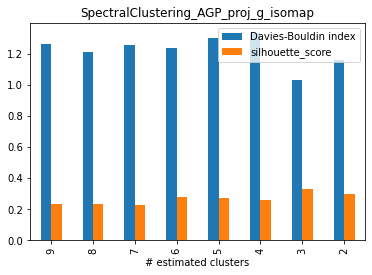

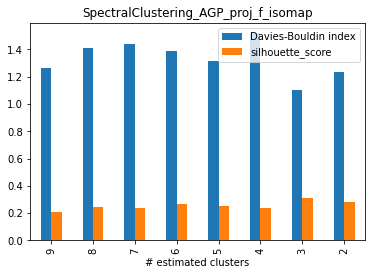

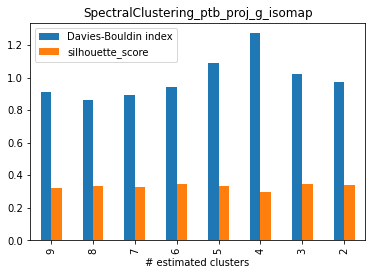

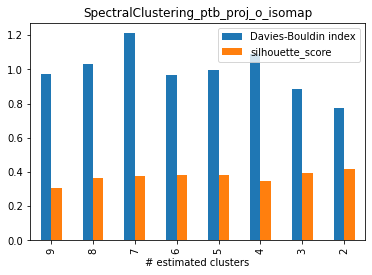

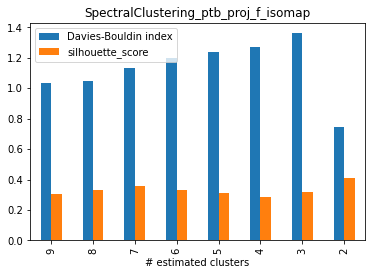

In [70]:
# plot_proj_clustering(isomap_cluster_results_list[2], method='isomap', suptitle='SpectralClustering')

# LLE

In [14]:
LABEL2DBSCAN_PARAMS_LLE = {}
for label,data in data_lle.items():
    p95_list = get_neigh_perc(data)
    LABEL2DBSCAN_PARAMS_LLE[label] = [min(p95_list), max(p95_list)]

In [15]:
methods_dict_lle = {'dbscan':[DBSCAN, [None]*30],
                       'KMeans':[KMeans, np.arange(2, 10, 1)]}
#                        'SpectralClustering':[SpectralClustering, np.arange(2, 10, 1)]}

methods_names = list(methods_dict_lle.keys())

lle_cluster_results_list = []
lle_cluster_preds_list = []

for method_name in tqdm_notebook(methods_names):
    method_class, param_range = methods_dict_lle[method_name]
    cluster_results, cluster_preds = clustering(data_lle, 
                                                method_class, 
                                                param_range, 
                                                dbscan=method_name=='dbscan', 
                                                dbscan_params_dict=LABEL2DBSCAN_PARAMS_LLE)
    
    lle_cluster_results_list.append(cluster_results)
    lle_cluster_preds_list.append(cluster_preds)

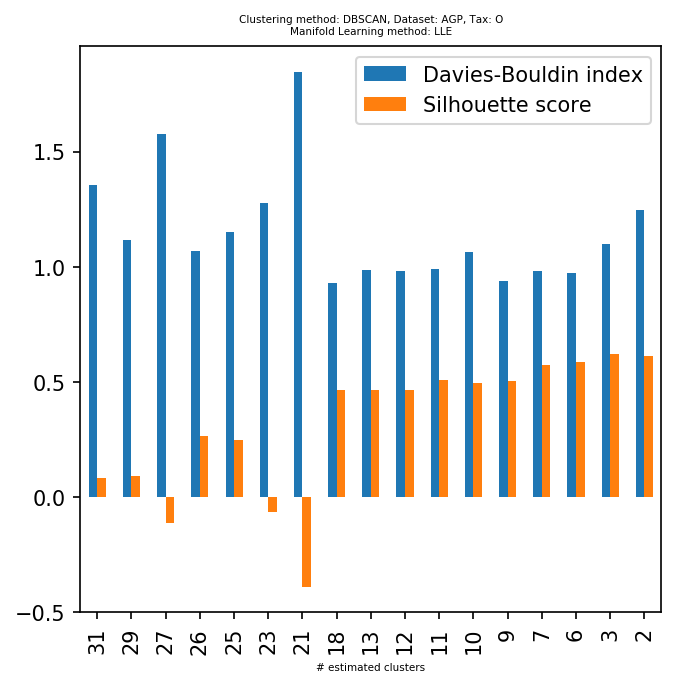

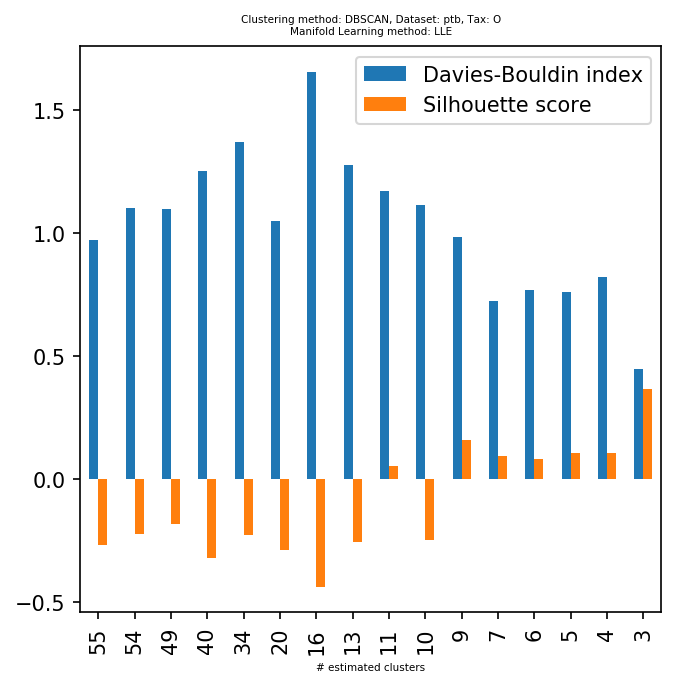

In [115]:
plot_proj_clustering(lle_cluster_results_list[0], method='Manifold Learning method: LLE', suptitle='Clustering method: DBSCAN')

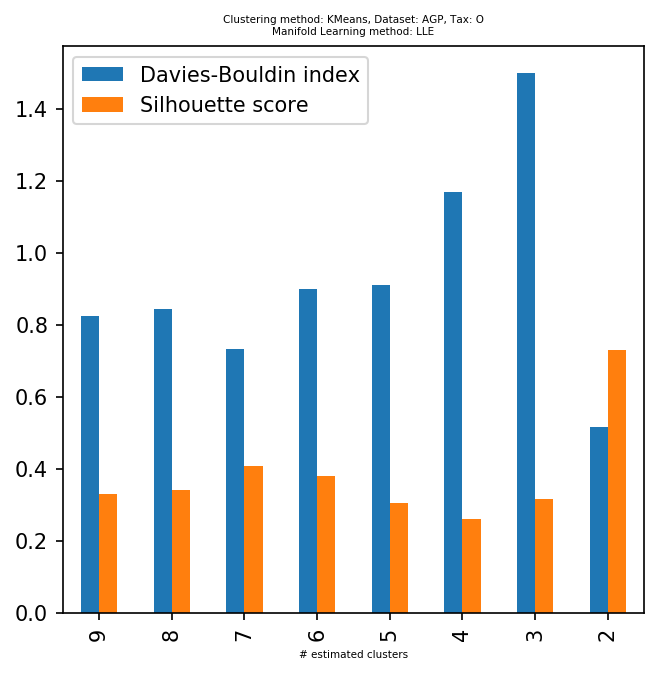

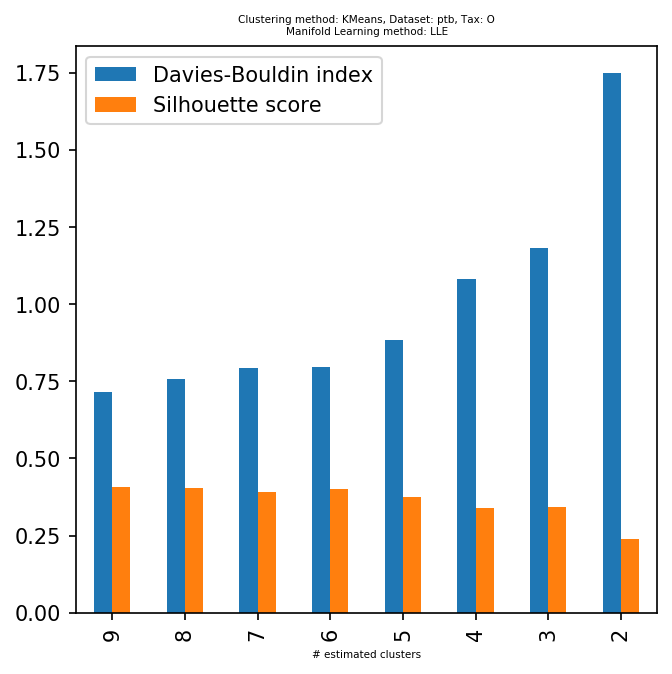

In [116]:
plot_proj_clustering(lle_cluster_results_list[1], method='Manifold Learning method: LLE', suptitle='Clustering method: KMeans')

In [20]:
get_report(methods_dict_lle, 
           lle_cluster_results_list, 
           lle_cluster_preds_list, 
           silh_thresh=0.6,
           H_thresh=0.0,  
           dbind_thresh=0.6)

------------------------------
dbscan
------------------------------
------------------------------
KMeans
Ratio for AGP_proj_o, for n_clusters=2, H=0.05155227761033262, ratios=[0.991 0.009], DBind=0.5159851642409913, Silh=0.7299554766824937
------------------------------


In [21]:
data_lle['AGP_proj_o'].shape

(9511, 6)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


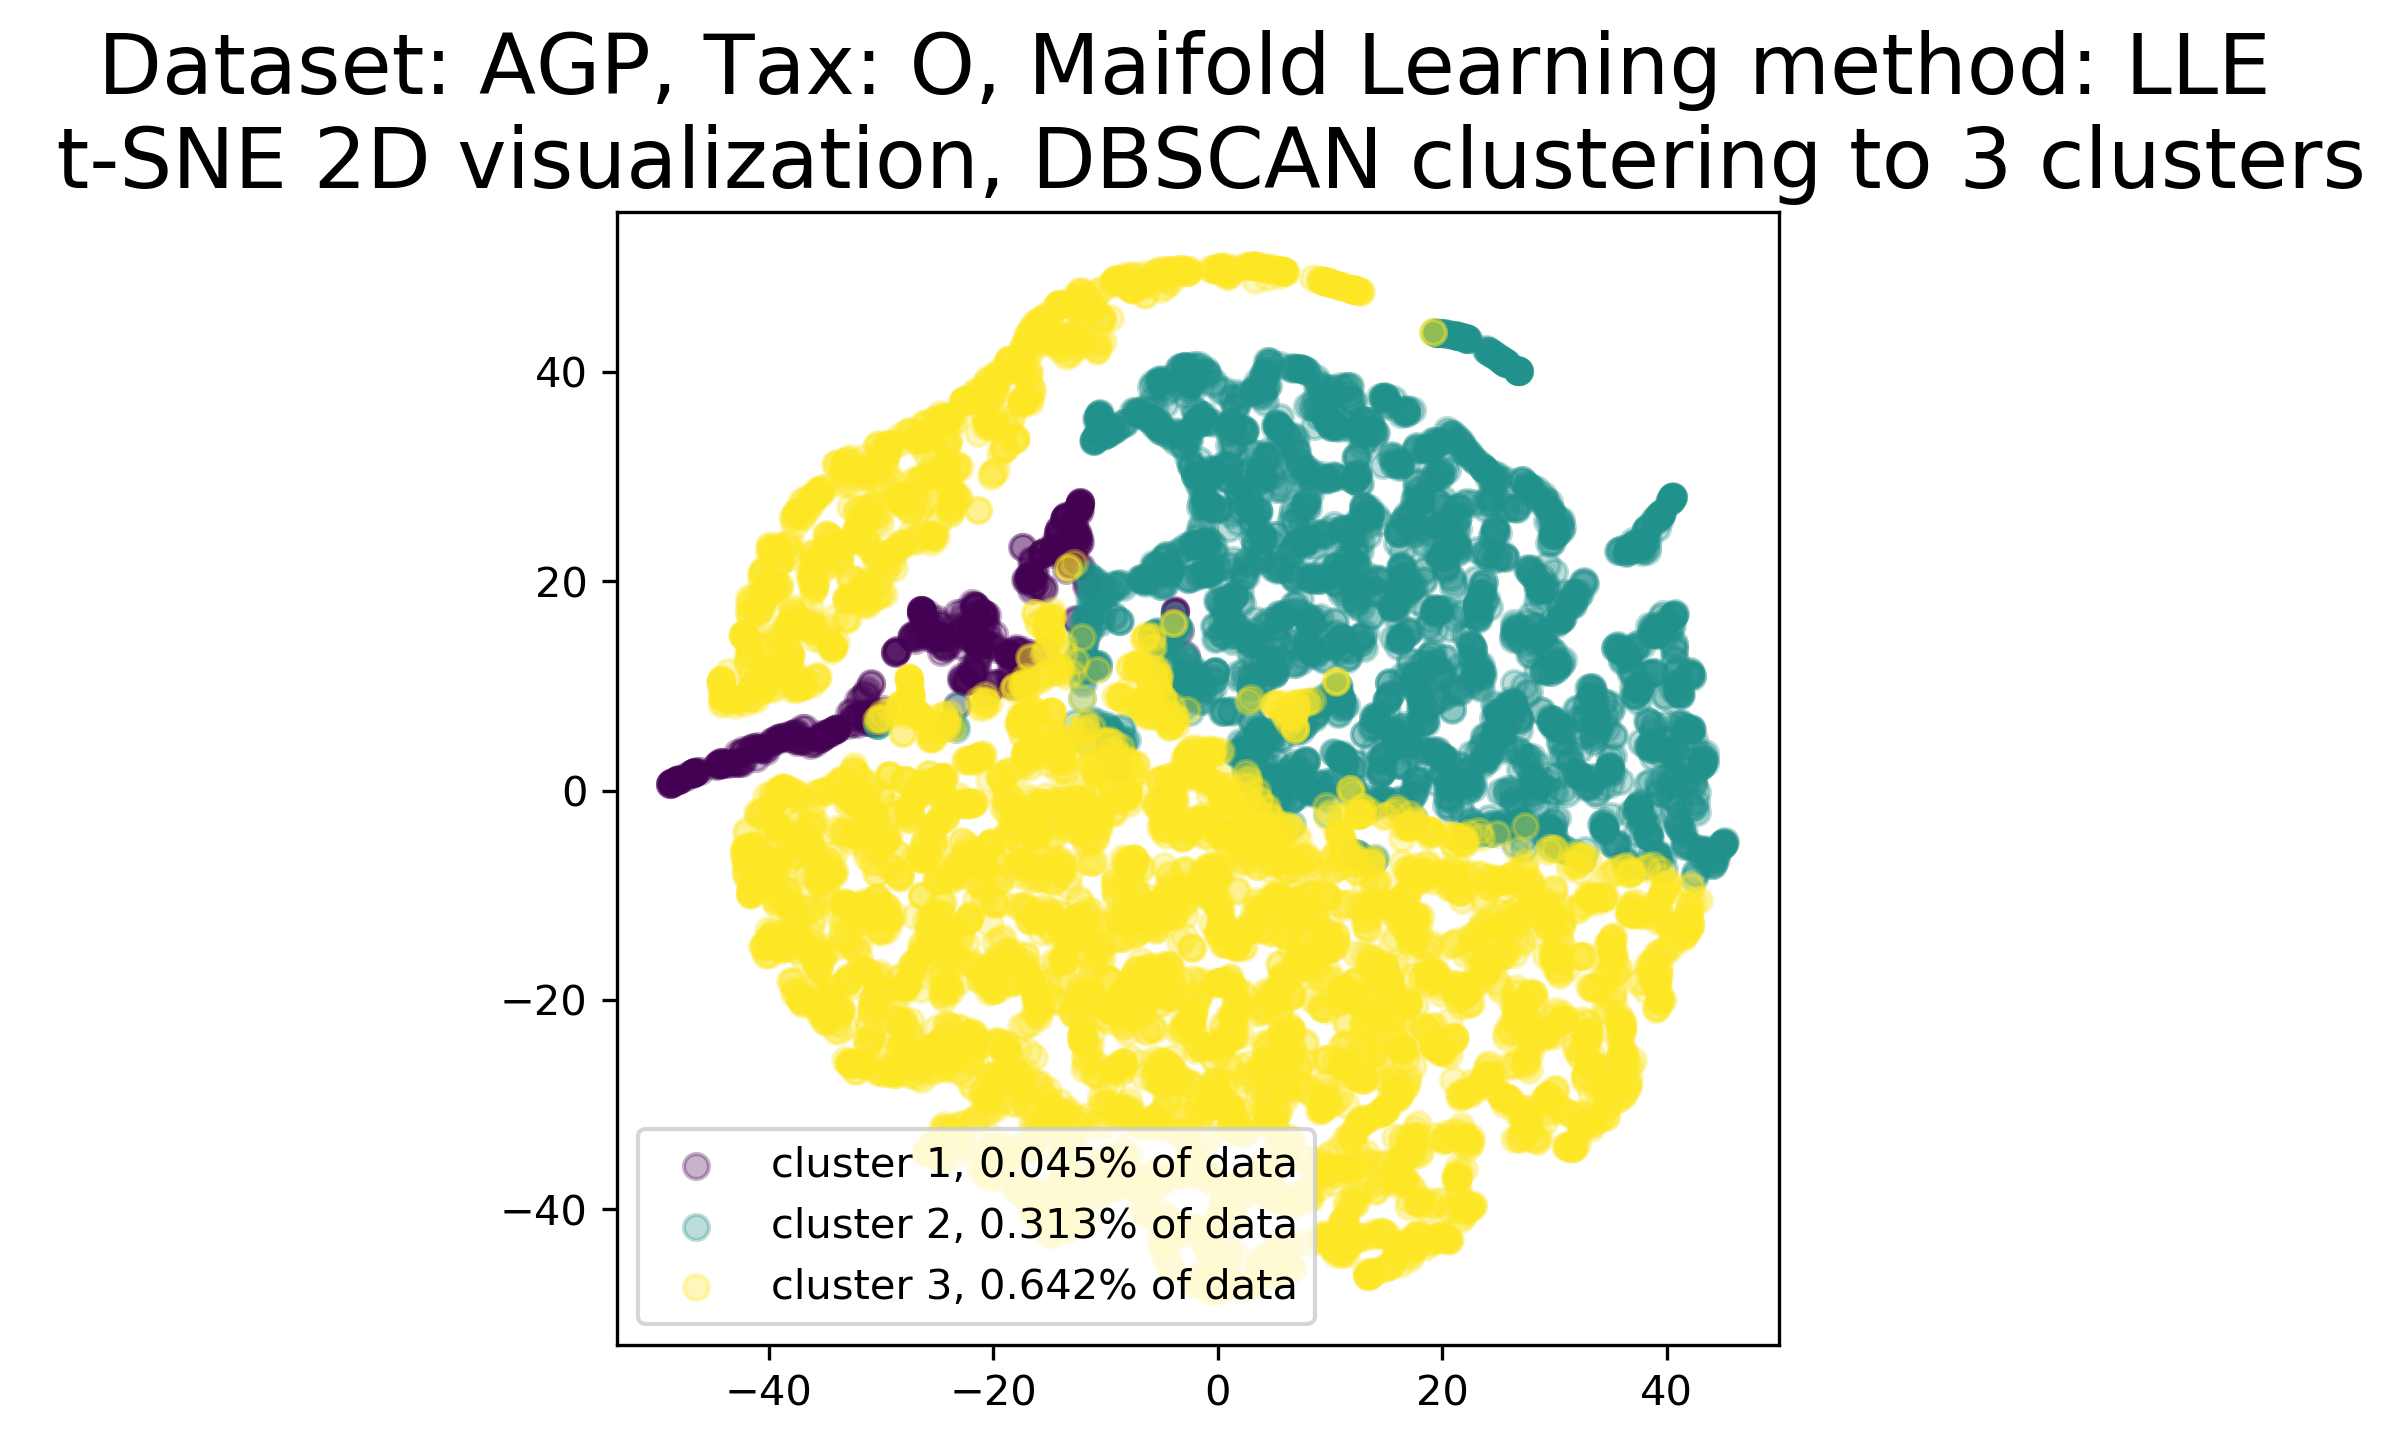

In [86]:
DISTINCT_CLUSTERS_LLE_NAME = 'AGP_proj_o'
DISTINCT_CLUSTERS_RESULTS_LLE = {DISTINCT_CLUSTERS_LLE_NAME:{'DBSCAN':[lle_cluster_preds_list[1][DISTINCT_CLUSTERS_LLE_NAME], 3]}}

# TSNE
for label, preds_dict in DISTINCT_CLUSTERS_RESULTS_LLE.items():
    for method_name, (preds, n_clusters) in preds_dict.items():
        dataset = data_lle[label]
        dataset_name = label.split('_')[0]
        tax_name = label.split('_')[-1].upper()
        # TSNE
#         tsne2 = TSNE(2, init='pca', verbose=0, angle=0.3, perplexity=20, n_iter=1000, random_state=RANDOM_SEED)
#         tsne2.fit(dataset)
#         embedding = tsne2.embedding_
        plt.figure(figsize=FIGSIZE, dpi=DPI)
        colors = [cm.get_cmap('viridis')(it) for it in np.linspace(0,1,n_clusters)]
        for c_number in range(n_clusters):
            mask = preds[n_clusters] == c_number
            perc = round(mask.sum()/len(mask),3)
            plt.scatter(embedding[:,0][mask], embedding[:,1][mask], alpha=0.3, c=colors[c_number], label=f'cluster {c_number+1}, {perc}% of data')
        plt.title(f'Dataset: {dataset_name}, Tax: {tax_name}, Maifold Learning method: LLE \n t-SNE 2D visualization, {method_name} clustering to {n_clusters} clusters',fontsize=FONTSIZE)
        plt.legend()
        # PROJECTIONS
#         N = dataset.shape[1]
#         for (d1,d2) in list(combinations(np.arange(N),2)):
#             plt.figure()
#             plt.scatter(dataset[:,d1], dataset[:,d2], alpha=0.1, c=preds[n_clusters])
#             plt.title(f'{dataset_name}, DIMS:{d1,d2}, {method_name} clustering to n_clust={n_clusters}')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


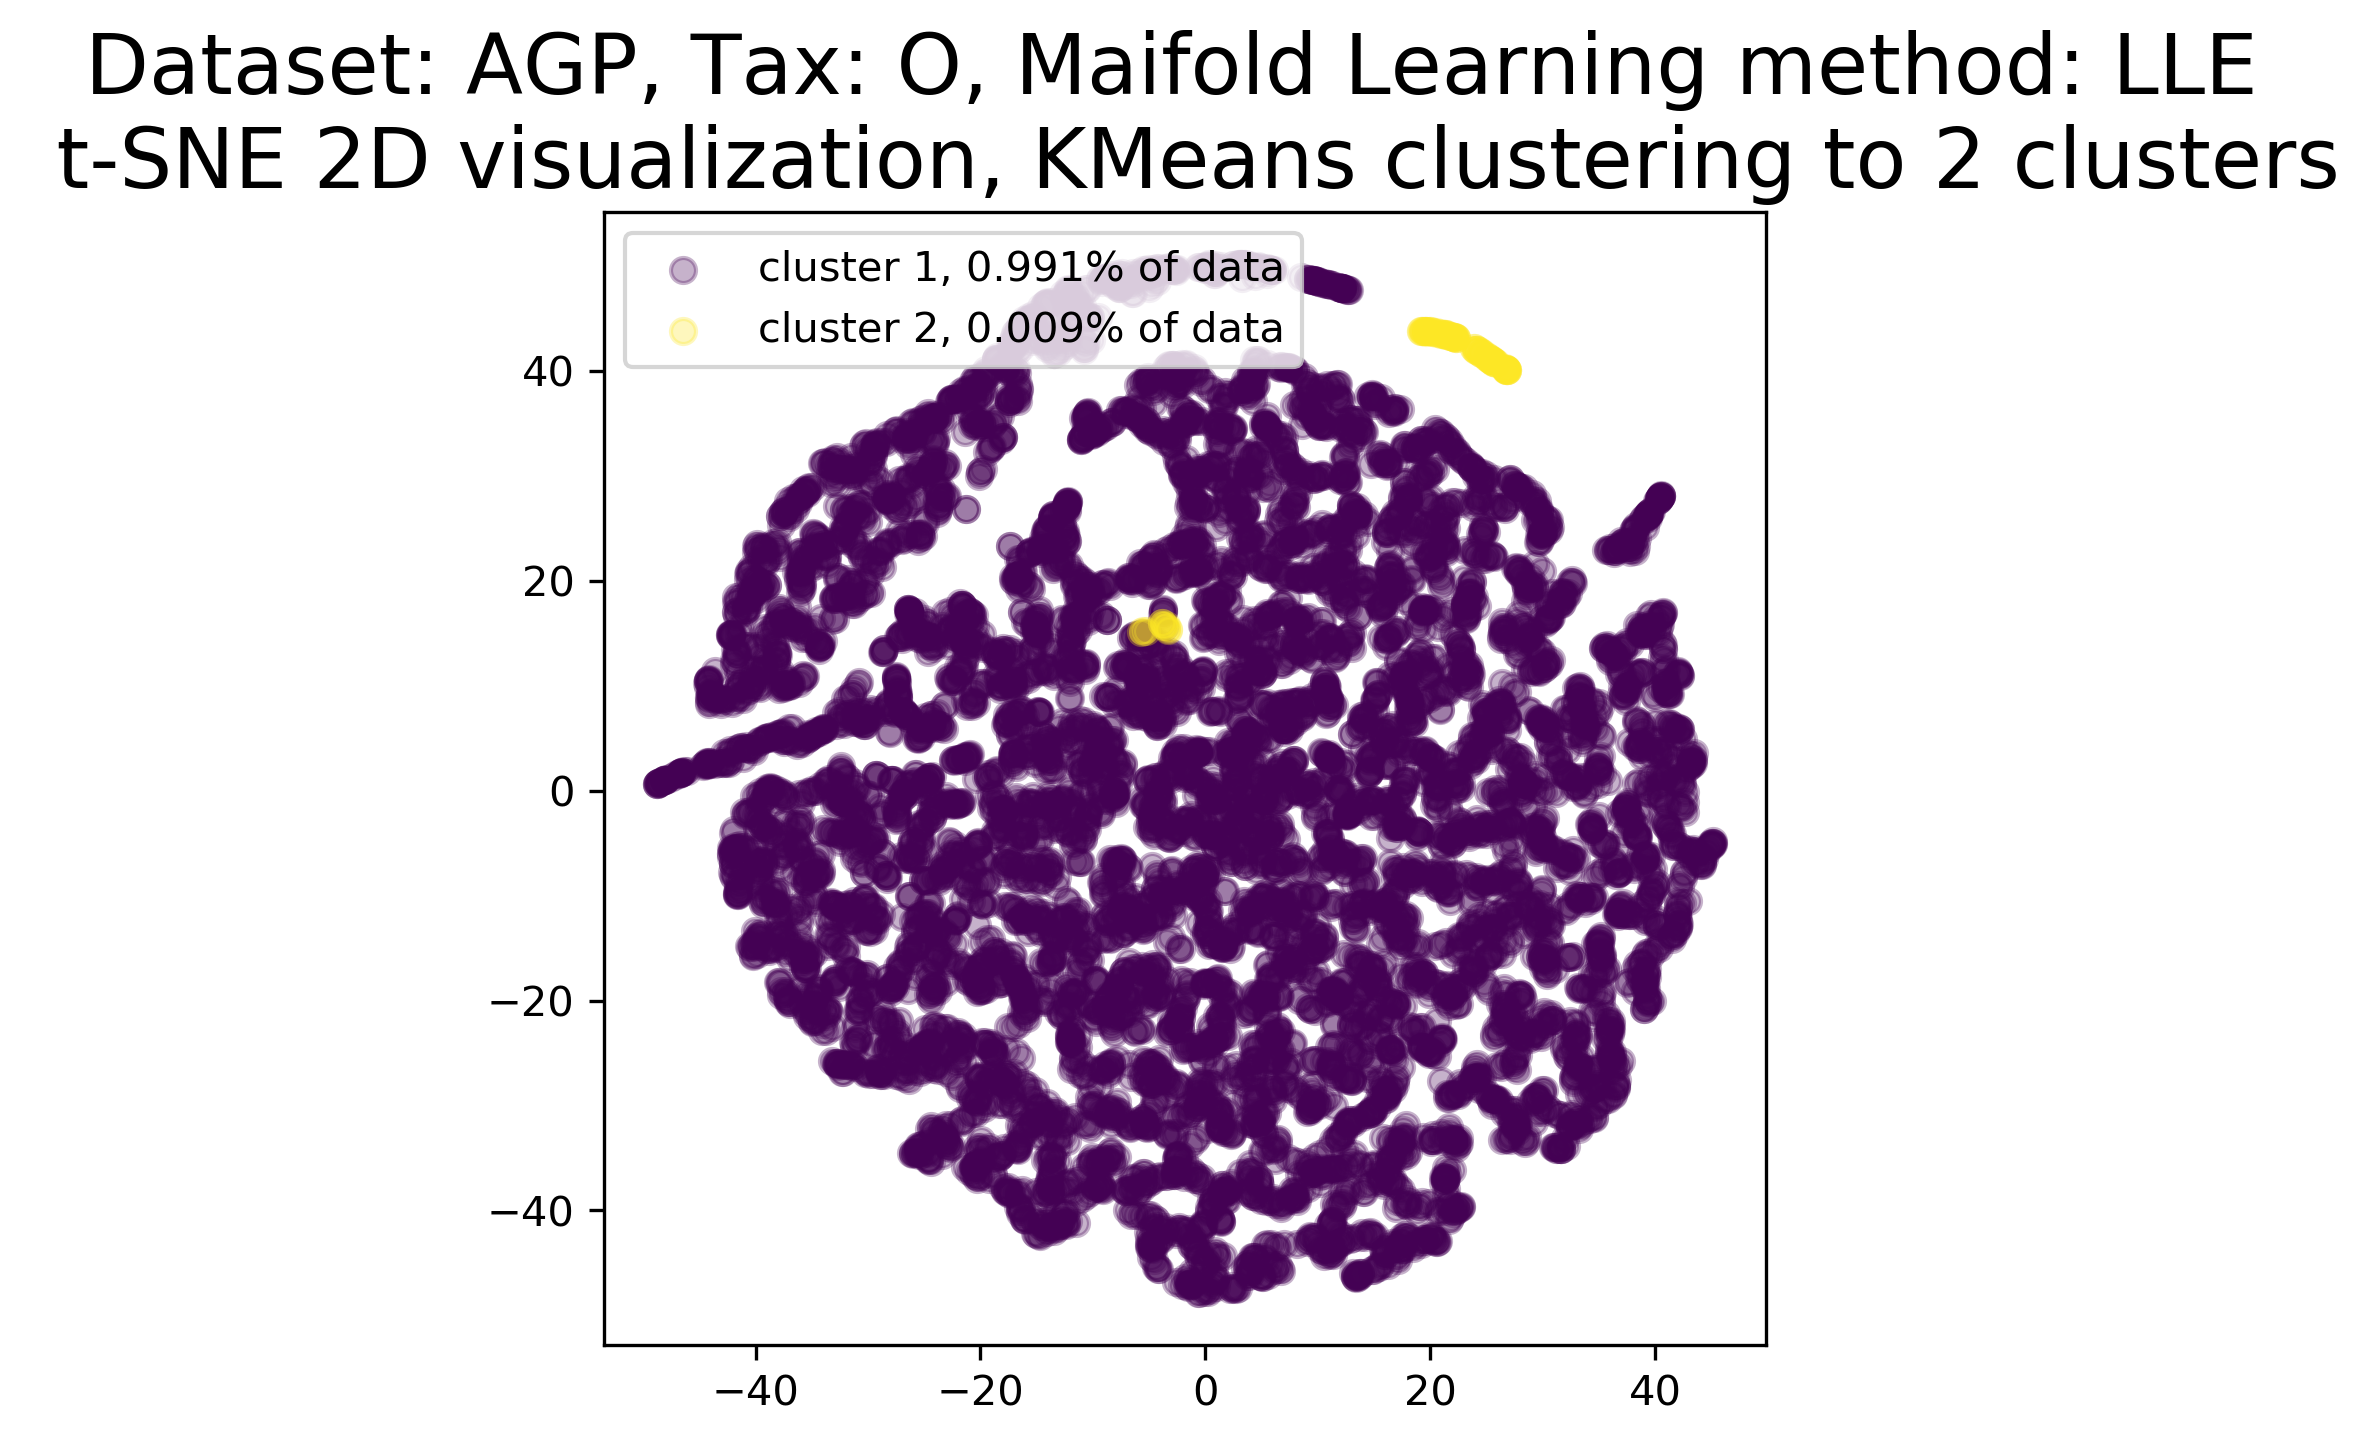

In [87]:
DISTINCT_CLUSTERS_LLE_NAME = 'AGP_proj_o'
DISTINCT_CLUSTERS_RESULTS_LLE = {DISTINCT_CLUSTERS_LLE_NAME:{'KMeans':[lle_cluster_preds_list[1][DISTINCT_CLUSTERS_LLE_NAME], 2]}}

# TSNE
for label, preds_dict in DISTINCT_CLUSTERS_RESULTS_LLE.items():
    for method_name, (preds, n_clusters) in preds_dict.items():
        dataset = data_lle[label]
        dataset_name = label.split('_')[0]
        tax_name = label.split('_')[-1].upper()
        # TSNE
#         tsne2 = TSNE(2, init='pca', verbose=0, angle=0.3, perplexity=20, n_iter=1000, random_state=RANDOM_SEED)
#         tsne2.fit(dataset)
#         embedding = tsne2.embedding_
        plt.figure(figsize=FIGSIZE, dpi=DPI)
        colors = [cm.get_cmap('viridis')(it) for it in np.linspace(0,1,n_clusters)]
        for c_number in range(n_clusters):
            mask = preds[n_clusters] == c_number
            perc = round(mask.sum()/len(mask),3)
            plt.scatter(embedding[:,0][mask], embedding[:,1][mask], alpha=0.3, c=colors[c_number], label=f'cluster {c_number+1}, {perc}% of data')
        plt.title(f'Dataset: {dataset_name}, Tax: {tax_name}, Maifold Learning method: LLE \n t-SNE 2D visualization, {method_name} clustering to {n_clusters} clusters',fontsize=FONTSIZE)
        plt.legend()
        # PROJECTIONS
#         N = dataset.shape[1]
#         for (d1,d2) in list(combinations(np.arange(N),2)):
#             plt.figure()
#             plt.scatter(dataset[:,d1], dataset[:,d2], alpha=0.1, c=preds[n_clusters])
#             plt.title(f'{dataset_name}, DIMS:{d1,d2}, {method_name} clustering to n_clust={n_clusters}')
plt.show()

# Clustering according to pre-defined enterotypes